# Определение возраста покупателей

<b>Описание проекта</b>

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя.

 __Задачи проекта.__
 <li>Провести исследовательский анализ набора фотографий.</li>
 <li>Подготовить данные к обучению.</li>
 <li>Подготовить данные к обучению.</li>

## Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import warnings
warnings.filterwarnings('ignore')

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Text(0.5, 0, 'Возраст')

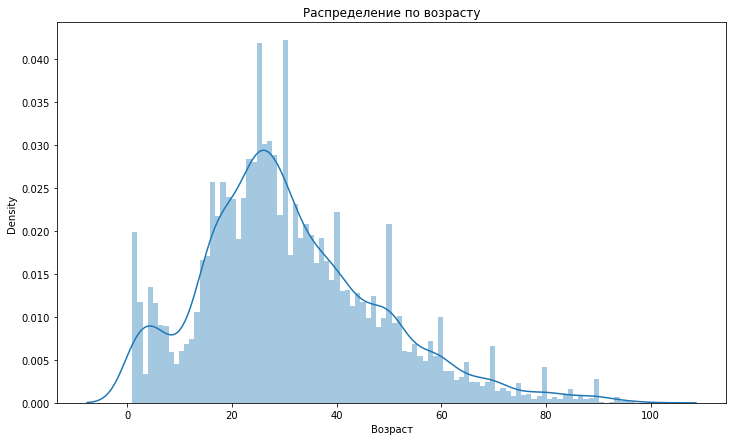

In [4]:
plt.figure(figsize=(12,7))
sns.distplot(labels['real_age'], bins=100)
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')

In [5]:
labels['real_age'].value_counts(ascending=False).head(20)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
22    179
20    178
32    174
40    167
29    164
17    163
34    156
50    156
1     149
35    147
Name: real_age, dtype: int64

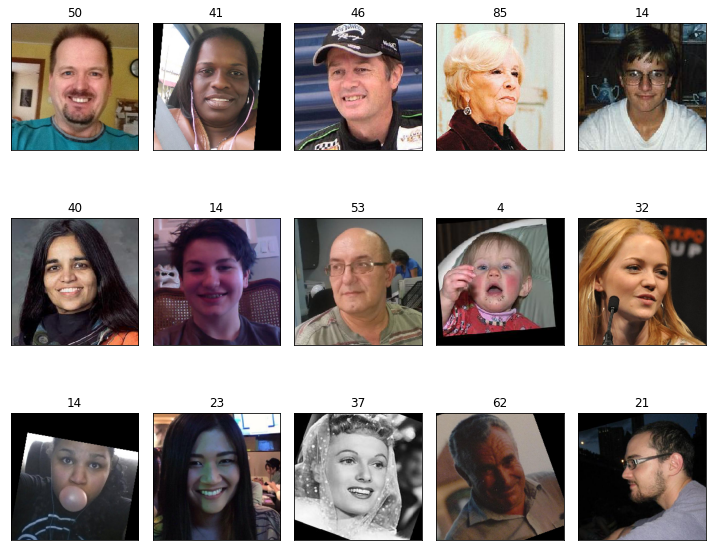

In [6]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<b>Вывод</b>
* В таблице присутствуе 7591 строка и два столбца типа integer и текст;
* График распределения возрастов близок к нормальному. Большая часть людей находится в возрасте от 19 до 40 лет;
* Фотографии представленные в дф имеют разный вид. Некоторые цветные,некоторые имеют поворо или являются обрезанными.



## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_absolute_error

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       validation_split=0.2,
                                       width_shift_range=0.2, 
                                       height_shift_range =0.2,
                                       horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

    
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
    return model

```

```

Train for 190 steps, validate for 48 steps
Epoch 1/10
2022-09-14 16:11:06.123353: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-14 16:11:07.019654: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 169s - loss: 234.5224 - mae: 10.9214 - val_loss: 691.8612 - val_mae: 21.2157
Epoch 2/10
190/190 - 101s - loss: 90.6146 - mae: 7.1985 - val_loss: 662.8616 - val_mae: 20.5560
Epoch 3/10
190/190 - 98s - loss: 69.8518 - mae: 6.3588 - val_loss: 209.3586 - val_mae: 10.6080
Epoch 4/10
190/190 - 96s - loss: 58.0441 - mae: 5.7919 - val_loss: 173.0605 - val_mae: 10.1399
Epoch 5/10
190/190 - 97s - loss: 49.8554 - mae: 5.4369 - val_loss: 100.8543 - val_mae: 7.4498
Epoch 6/10
190/190 - 97s - loss: 42.5422 - mae: 4.9892 - val_loss: 84.8835 - val_mae: 6.8906
Epoch 7/10
190/190 - 96s - loss: 37.7811 - mae: 4.7375 - val_loss: 70.2027 - val_mae: 6.2041
Epoch 8/10
190/190 - 96s - loss: 34.3167 - mae: 4.5039 - val_loss: 68.8985 - val_mae: 6.2309
Epoch 9/10
190/190 - 96s - loss: 29.0225 - mae: 4.1526 - val_loss: 65.6373 - val_mae: 6.0155
Epoch 10/10
190/190 - 96s - loss: 25.9390 - mae: 3.9312 - val_loss: 66.3294 - val_mae: 5.9199
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 66.3294 - mae: 5.9199
Test MAE: 5.9199


```

## Анализ обученной модели

* Создана нейронная сеть с архитектурой ResNet, с применением сверточных сетей; 
* Обучение модели проходило в 10 эпох с алгоритмом Adam, где learning_rate = 0.0001; 
* Максимальное количество секунд на обучение - 169 секунд. Минимальное - 96 секунд;
* Последняя 10 эпоха дала следующие результаты: MAE на обучающей выборке: 3.9312, MAE на валидационной выборке: 5.9199;
* Результат определяю как хороший (учитывая что в статье значение MAE равно 5.4), значит система определения возраста для компании можно запускать в прод.